In [1]:
import os
import numpy as np
import cv2
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc

# Task 1 : Create Global Color Histogram

In [2]:
## Images and Descriptors Location 

DATASET_FOLDER = 'MSRC_ObjCategImageDatabase_v2'
OUT_FOLDER = 'descriptors'
OUT_SUBFOLDER = 'globalRGBhisto' ## Output Folder for Color Histogram 

In [48]:
from cvpr_computedescriptors import create_global_color_hist

create_global_color_hist(8, # Level of Quantization
                         DATASET_FOLDER,
                         OUT_FOLDER,
                         OUT_SUBFOLDER) # Creates Descriptor based on Color Histogram 

Successfully Created Global Color Descriptors


In [49]:
from cvpr_visualsearch import load_descriptors
from cvpr_compare import cvpr_compare
from random import randint

DESCRIPTOR_FOLDER = 'descriptors'
DESCRIPTOR_SUBFOLDER = 'globalRGBhisto'
IMAGE_FOLDER = 'MSRC_ObjCategImageDatabase_v2'

COLOR_HIST_ALLFILES , COLOR_HIST_ALLFEAT = load_descriptors(IMAGE_FOLDER,
                                                         DESCRIPTOR_FOLDER,
                                                         DESCRIPTOR_SUBFOLDER)

# Pick a random image as the query
NIMG = COLOR_HIST_ALLFEAT.shape[0]
queryimg = randint(0, NIMG - 1)

# Compute the distance between the query and all other descriptors
dst = []
query = COLOR_HIST_ALLFEAT[queryimg]
for i in range(NIMG):
    candidate = COLOR_HIST_ALLFEAT[i]
    distance = cvpr_compare(query, candidate,'L2') 
    dst.append((distance, i))

# Sort the distances
dst.sort(key=lambda x: x[0])


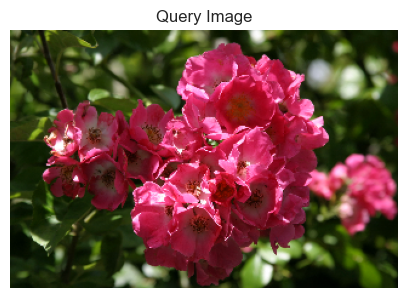

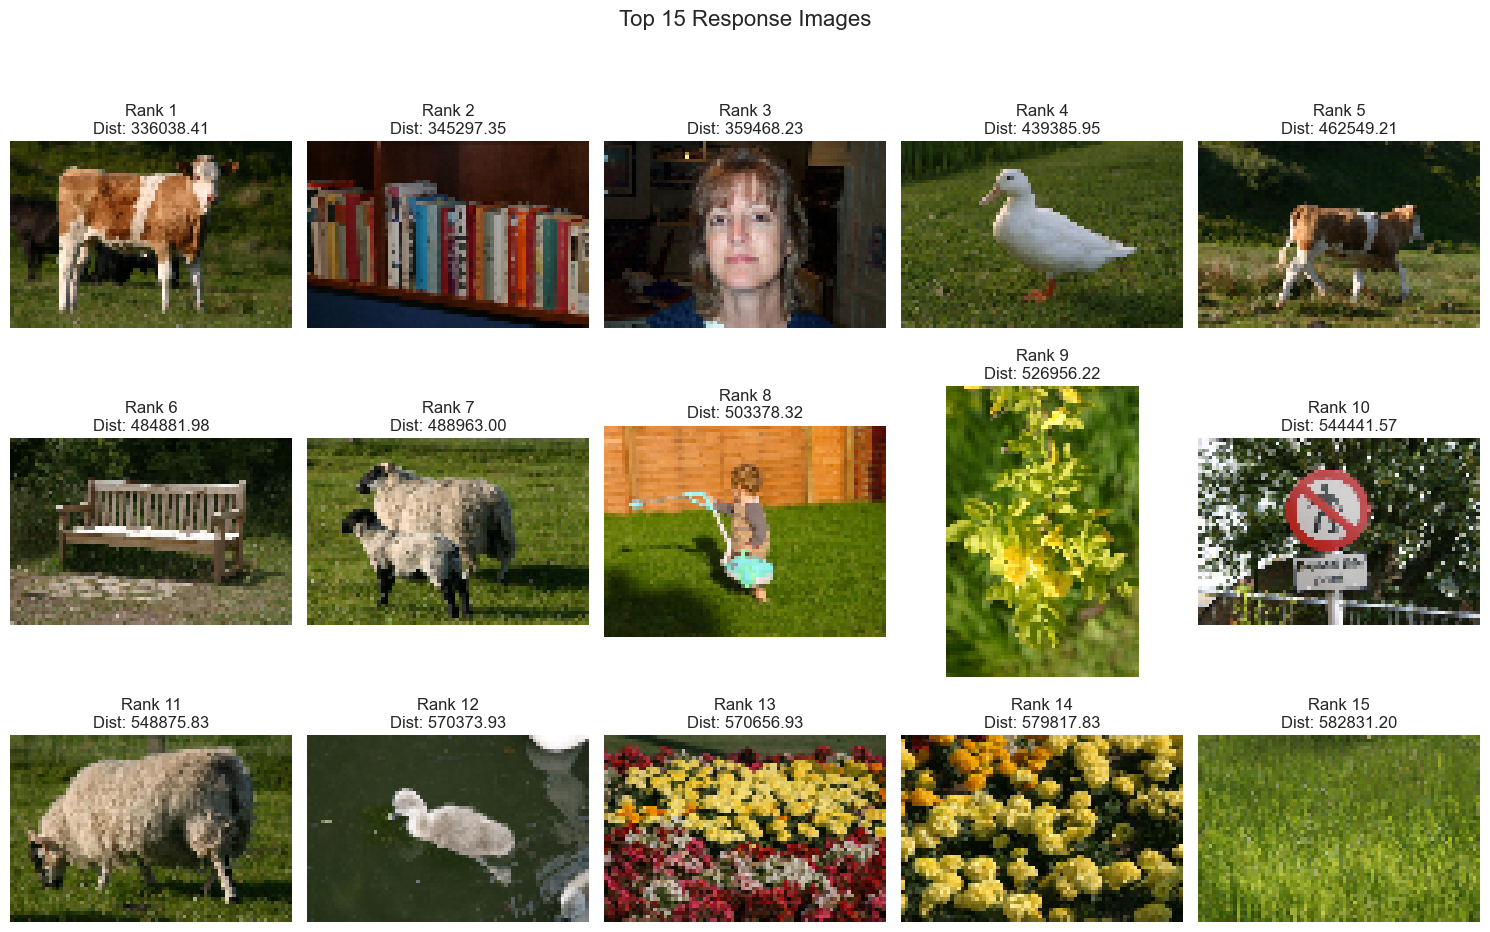

In [50]:
# Display the query image
plt.figure(figsize=(5, 5))
query_image_path = COLOR_HIST_ALLFILES[queryimg]
query_image = cv2.imread(query_image_path)
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
plt.imshow(query_image)
plt.title("Query Image")
plt.axis('off')
plt.show()

# Display the top 15 response images in a 3x5 grid layout
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle("Top 15 Response Images", fontsize=16)

for i in range(SHOW):
    img_index = dst[i + 1][1]  # Skipping the query image itself
    img_path = COLOR_HIST_ALLFILES[img_index]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4))  # Resize image for display

    # Determine position in the grid
    row, col = divmod(i, 5)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Rank {i + 1}\nDist: {dst[i + 1][0]:.2f}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top to fit the main title
plt.show()

# Task 2 : Generate Precision Recall Curve

In [55]:
from cvpr_evaluation import extract_class_and_file

response_class_no = []
for img_no in range(len(COLOR_HIST_ALLFILES)):
    temp_class , temp_file = extract_class_and_file(COLOR_HIST_ALLFILES[dst[img_no][1]])
    response_class_no.append(temp_class)
    

query_class =   response_class_no[0]
response_class = response_class_no[1:]

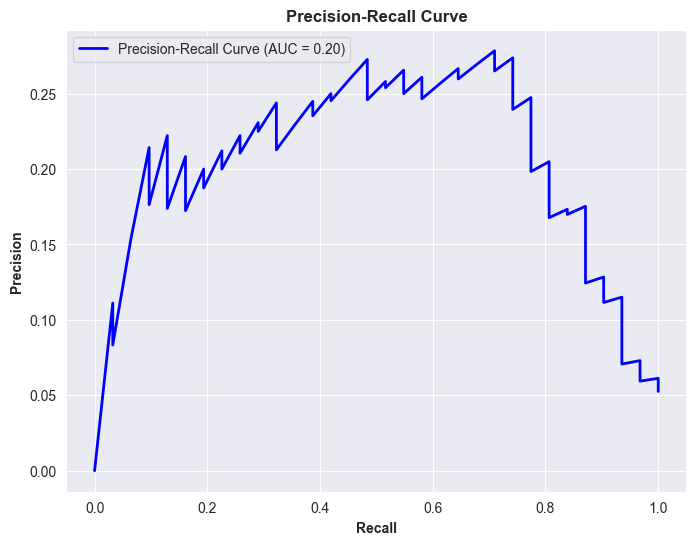

In [56]:
precision = []
recall = []
relevant_retrieved = 0
total_relevant = sum(1 for cls in response_class if cls == query_class)

for i, cls in enumerate(response_class):
    if cls == query_class:
        relevant_retrieved += 1
    
    current_precision = relevant_retrieved / (i + 1)
    current_recall = relevant_retrieved / total_relevant if total_relevant > 0 else 0

    precision.append(current_precision)
    recall.append(current_recall)

# Calculate AUC for the curve
pr_auc = auc(recall, precision)

# Set the style
sns.set_style("darkgrid")

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall', fontweight='bold')
plt.ylabel('Precision', fontweight='bold')
plt.title('Precision-Recall Curve', fontweight='bold')
plt.legend(loc='best')
plt.show()

# Task 3 : Spatial Grid (Colour and Texture)

In [70]:
def sobel_quantization(image, num_bins=8):
    # Apply Sobel filter to get gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in x-direction
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in y-direction

    # Calculate magnitude and angle of gradient
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    angle = np.arctan2(sobely, sobelx)  # Angle in radians

    # Convert angle to degrees for easier quantization (range -180 to 180 degrees)
    angle = np.degrees(angle)
    angle[angle < 0] += 360  # Normalize to 0-360 degrees

    # Quantize angles into `num_bins` angular bins
    bin_width = 360 / num_bins
    quantized_angles = np.floor(angle / bin_width).astype(int) % num_bins

    # Quantize magnitudes into `num_bins` bins
    # Normalize the magnitude to a range [0, 1] for quantization
    magnitude_normalized = magnitude / np.max(magnitude) if np.max(magnitude) > 0 else magnitude
    quantized_magnitudes = np.floor(magnitude_normalized * num_bins).astype(int)  # Scale and quantize

    # Ensure the quantized magnitudes fit within the bin range
    quantized_magnitudes[quantized_magnitudes >= num_bins] = num_bins - 1  # Cap at max bin

    return quantized_angles, quantized_magnitudes, magnitude

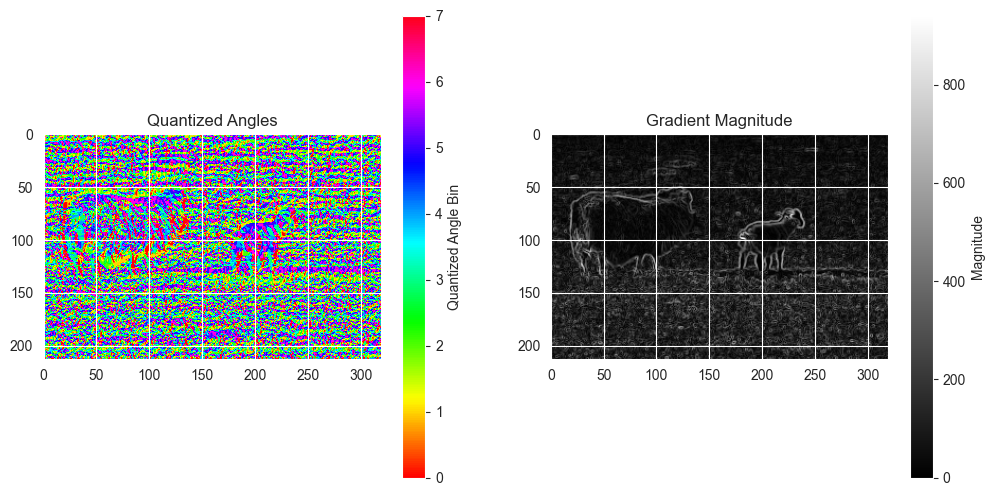

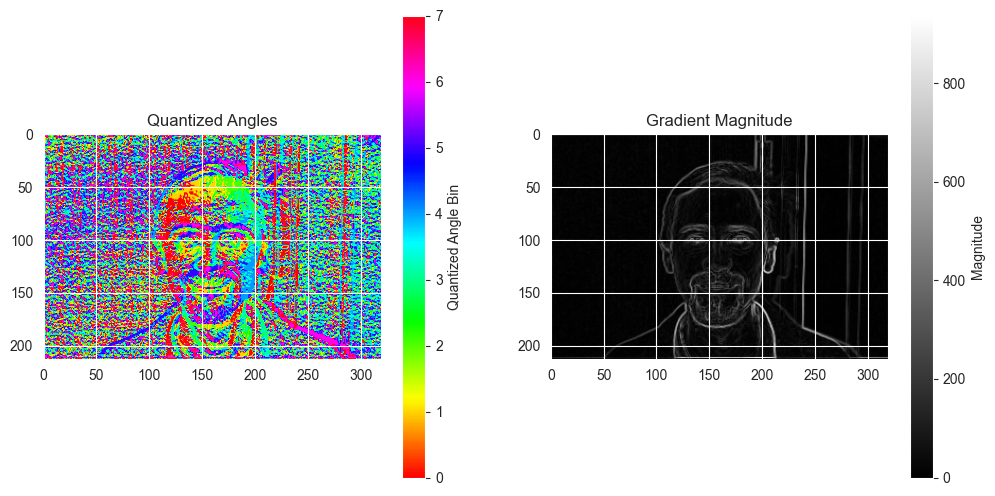

In [72]:
for image_path in COLOR_HIST_ALLFILES[:2]:
    # Read image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Failed to load image: {image_path}")
        continue

    # Perform Sobel and angular quantization
    quantized_angles, quantized_magnitudes,magnitude = sobel_quantization(image, num_bins=8)

    # Visualize the quantized angles and magnitude
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(quantized_angles, cmap='hsv')  # Visualize quantized angles
    plt.title("Quantized Angles")
    plt.colorbar(label="Quantized Angle Bin")

    plt.subplot(1, 2, 2)
    plt.imshow(magnitude, cmap='gray')  # Visualize magnitude
    plt.title("Gradient Magnitude")
    plt.colorbar(label="Magnitude")

    plt.show()

In [73]:
num_angular_bins = 8 

ANGULAR_HIST_ALLFILES = []
MAGNITUDE_HIST_ALLFILES = []

for IMG_PATH in COLOR_HIST_ALLFILES:
    image = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
    
    # Perform Sobel and angular quantization
    quantized_angles, quantized_magnitudes,magnitude = sobel_angular_quantization(image, 
                                                                                  num_bins=num_angular_bins)
   
    temp_ang_arr = [] # Contains individual img angular hist data
    temp_mag_arr = [] # Contains individual img magnitude hist data 
    
    for i in range(num_angular_bins):
        temp_ang_arr.append(sum(quantized_angles.flatten() == i))
        temp_mag_arr.append(sum(quantized_magnitudes.flatten() == i))
        
    ANGULAR_HIST_ALLFILES.append(temp_ang_arr)
    MAGNITUDE_HIST_ALLFILES.append(temp_mag_arr)
    
ANGULAR_HIST_ALLFILES = np.array(ANGULAR_HIST_ALLFILES) # Contains angular Hist for all the images
MAGNITUDE_HIST_ALLFILES = np.array(MAGNITUDE_HIST_ALLFILES) # Contains magnitude Hist for all the images

In [78]:
COL_ANG_HIST_ALLFILES = np.concatenate((COLOR_HIST_ALLFEAT, ANGULAR_HIST_ALLFILES), axis=1)
COL_MAG_HIST_ALLFILES = np.concatenate((COLOR_HIST_ALLFEAT, MAGNITUDE_HIST_ALLFILES), axis=1)

COL_ANG_MAG_HIST_ALLFILES = np.concatenate((COL_ANG_HIST_ALLFILES, MAGNITUDE_HIST_ALLFILES), axis=1)


### Task 3.1 : Peformance Based on Colour + Angular Histogram  

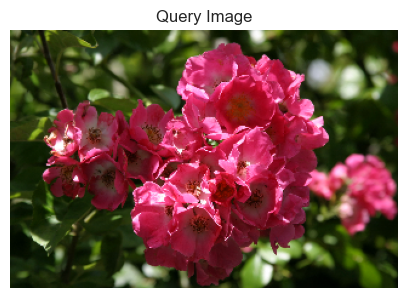

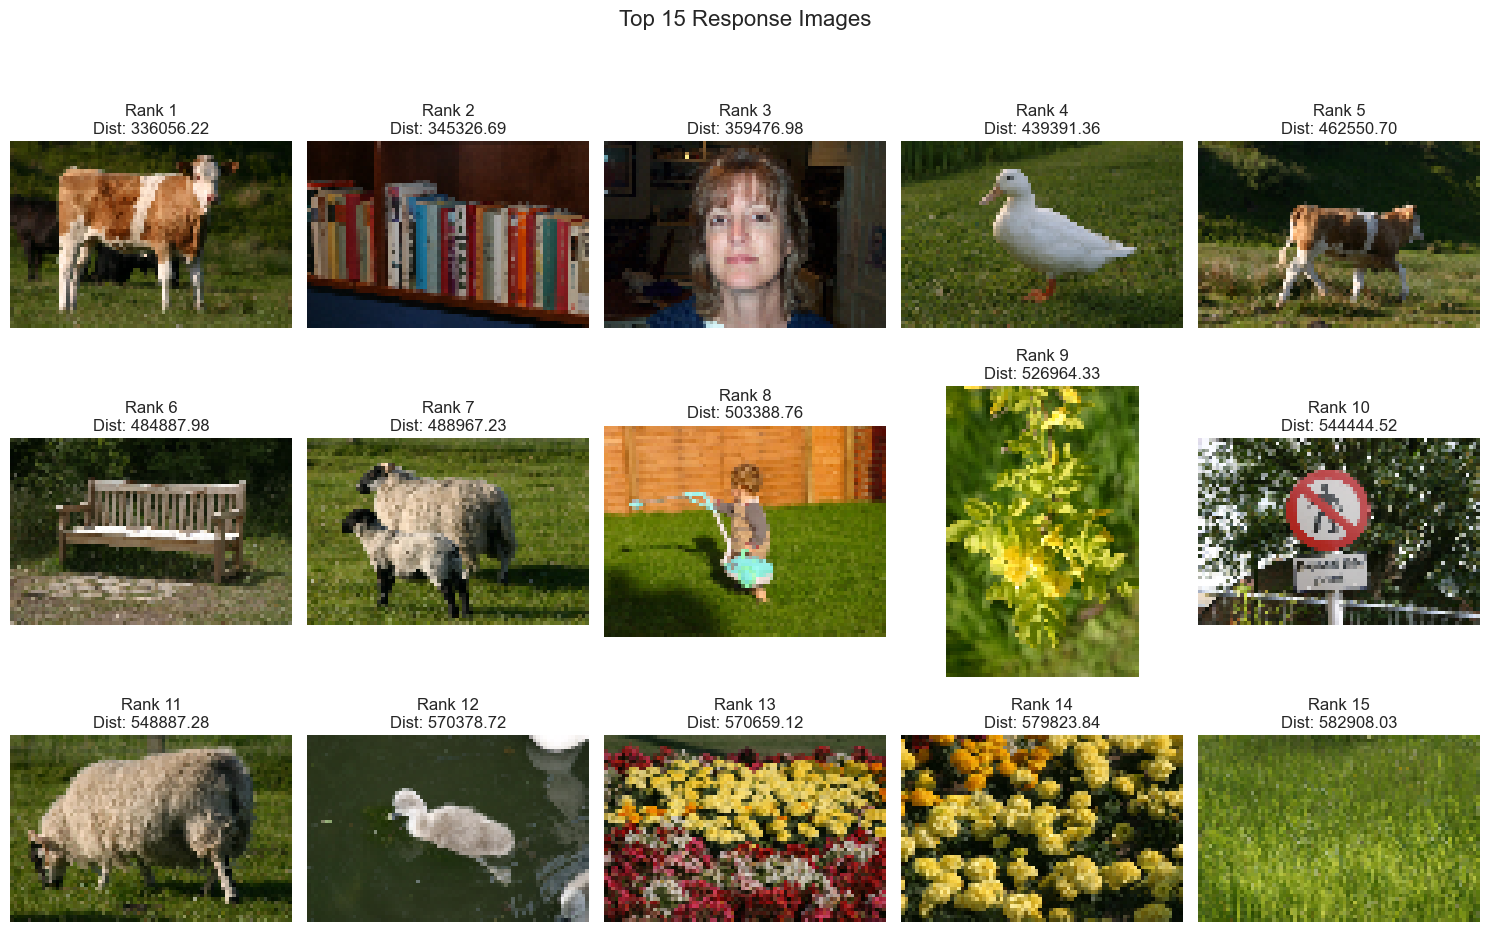

In [86]:
# Compute the distance between the query and all other descriptors
dst = []
query = COL_ANG_HIST_ALLFILES[queryimg]
for i in range(NIMG):
    candidate = COL_ANG_HIST_ALLFILES[i]
    distance = cvpr_compare(query, candidate,'L2') 
    dst.append((distance, i))

# Sort the distances
dst.sort(key=lambda x: x[0])

# Display the query image
plt.figure(figsize=(5, 5))
query_image_path = COLOR_HIST_ALLFILES[queryimg]
query_image = cv2.imread(query_image_path)
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
plt.imshow(query_image)
plt.title("Query Image")
plt.axis('off')
plt.show()

# Display the top 15 response images in a 3x5 grid layout
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle("Top 15 Response Images", fontsize=16)

for i in range(SHOW):
    img_index = dst[i + 1][1]  # Skipping the query image itself
    img_path = COLOR_HIST_ALLFILES[img_index]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4))  # Resize image for display

    # Determine position in the grid
    row, col = divmod(i, 5)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Rank {i + 1}\nDist: {dst[i + 1][0]:.2f}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top to fit the main title
plt.show()

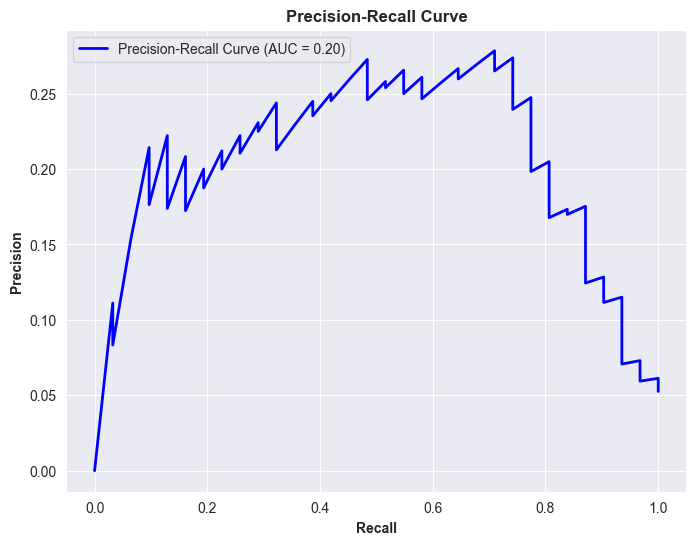

In [87]:
from cvpr_evaluation import extract_class_and_file

response_class_no = []
for img_no in range(len(COLOR_HIST_ALLFILES)):
    temp_class , temp_file = extract_class_and_file(COLOR_HIST_ALLFILES[dst[img_no][1]])
    response_class_no.append(temp_class)
    

query_class =   response_class_no[0]
response_class = response_class_no[1:]

precision = []
recall = []
relevant_retrieved = 0
total_relevant = sum(1 for cls in response_class if cls == query_class)

for i, cls in enumerate(response_class):
    if cls == query_class:
        relevant_retrieved += 1
    
    current_precision = relevant_retrieved / (i + 1)
    current_recall = relevant_retrieved / total_relevant if total_relevant > 0 else 0

    precision.append(current_precision)
    recall.append(current_recall)

# Calculate AUC for the curve
pr_auc = auc(recall, precision)

# Set the style
sns.set_style("darkgrid")

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall', fontweight='bold')
plt.ylabel('Precision', fontweight='bold')
plt.title('Precision-Recall Curve', fontweight='bold')
plt.legend(loc='best')
plt.show()

### 3.2 : Peformance Based on Colour + Mag Histogram  

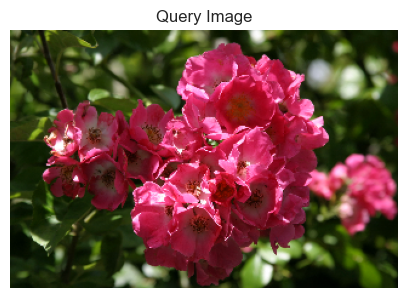

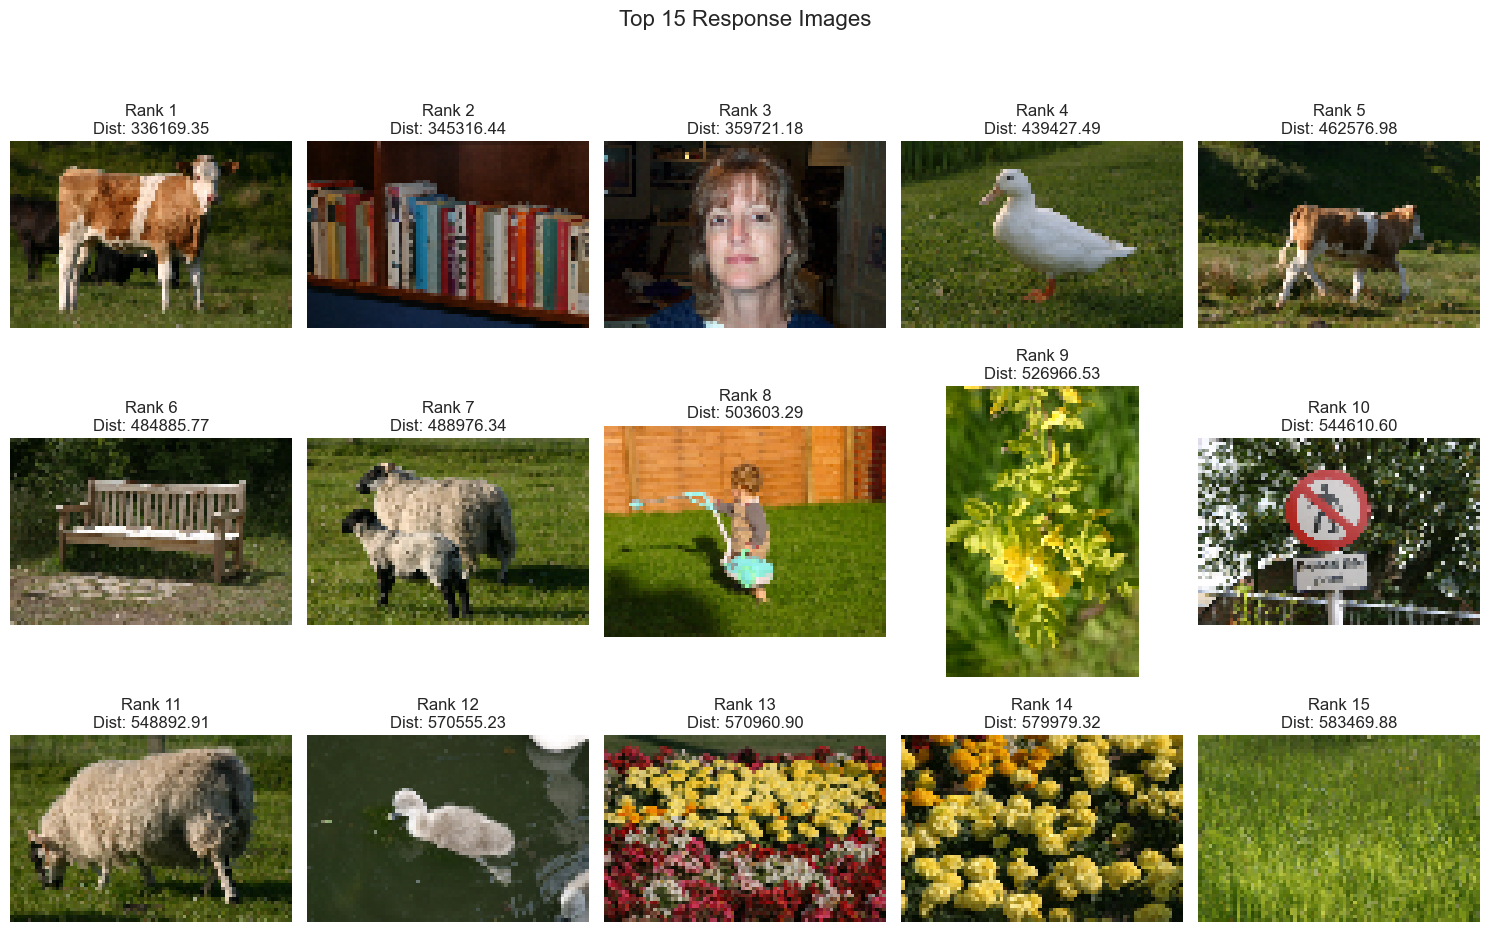

In [89]:
# Compute the distance between the query and all other descriptors
dst = []
query = COL_MAG_HIST_ALLFILES[queryimg]
for i in range(NIMG):
    candidate = COL_MAG_HIST_ALLFILES[i]
    distance = cvpr_compare(query, candidate,'L2') 
    dst.append((distance, i))

# Sort the distances
dst.sort(key=lambda x: x[0])

# Display the query image
plt.figure(figsize=(5, 5))
query_image_path = COLOR_HIST_ALLFILES[queryimg]
query_image = cv2.imread(query_image_path)
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
plt.imshow(query_image)
plt.title("Query Image")
plt.axis('off')
plt.show()

# Display the top 15 response images in a 3x5 grid layout
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle("Top 15 Response Images", fontsize=16)

for i in range(SHOW):
    img_index = dst[i + 1][1]  # Skipping the query image itself
    img_path = COLOR_HIST_ALLFILES[img_index]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4))  # Resize image for display

    # Determine position in the grid
    row, col = divmod(i, 5)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Rank {i + 1}\nDist: {dst[i + 1][0]:.2f}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top to fit the main title
plt.show()

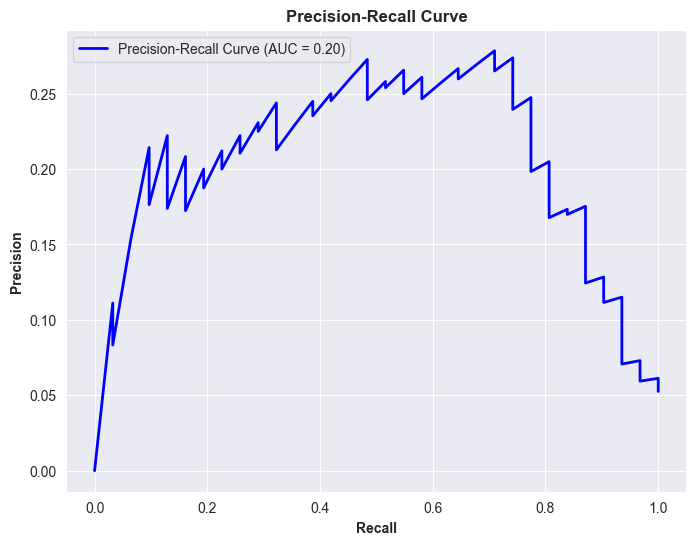

In [90]:
from cvpr_evaluation import extract_class_and_file

response_class_no = []
for img_no in range(len(COLOR_HIST_ALLFILES)):
    temp_class , temp_file = extract_class_and_file(COLOR_HIST_ALLFILES[dst[img_no][1]])
    response_class_no.append(temp_class)
    

query_class =   response_class_no[0]
response_class = response_class_no[1:]

precision = []
recall = []
relevant_retrieved = 0
total_relevant = sum(1 for cls in response_class if cls == query_class)

for i, cls in enumerate(response_class):
    if cls == query_class:
        relevant_retrieved += 1
    
    current_precision = relevant_retrieved / (i + 1)
    current_recall = relevant_retrieved / total_relevant if total_relevant > 0 else 0

    precision.append(current_precision)
    recall.append(current_recall)

# Calculate AUC for the curve
pr_auc = auc(recall, precision)

# Set the style
sns.set_style("darkgrid")

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall', fontweight='bold')
plt.ylabel('Precision', fontweight='bold')
plt.title('Precision-Recall Curve', fontweight='bold')
plt.legend(loc='best')
plt.show()

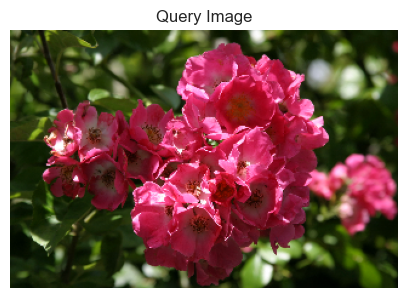

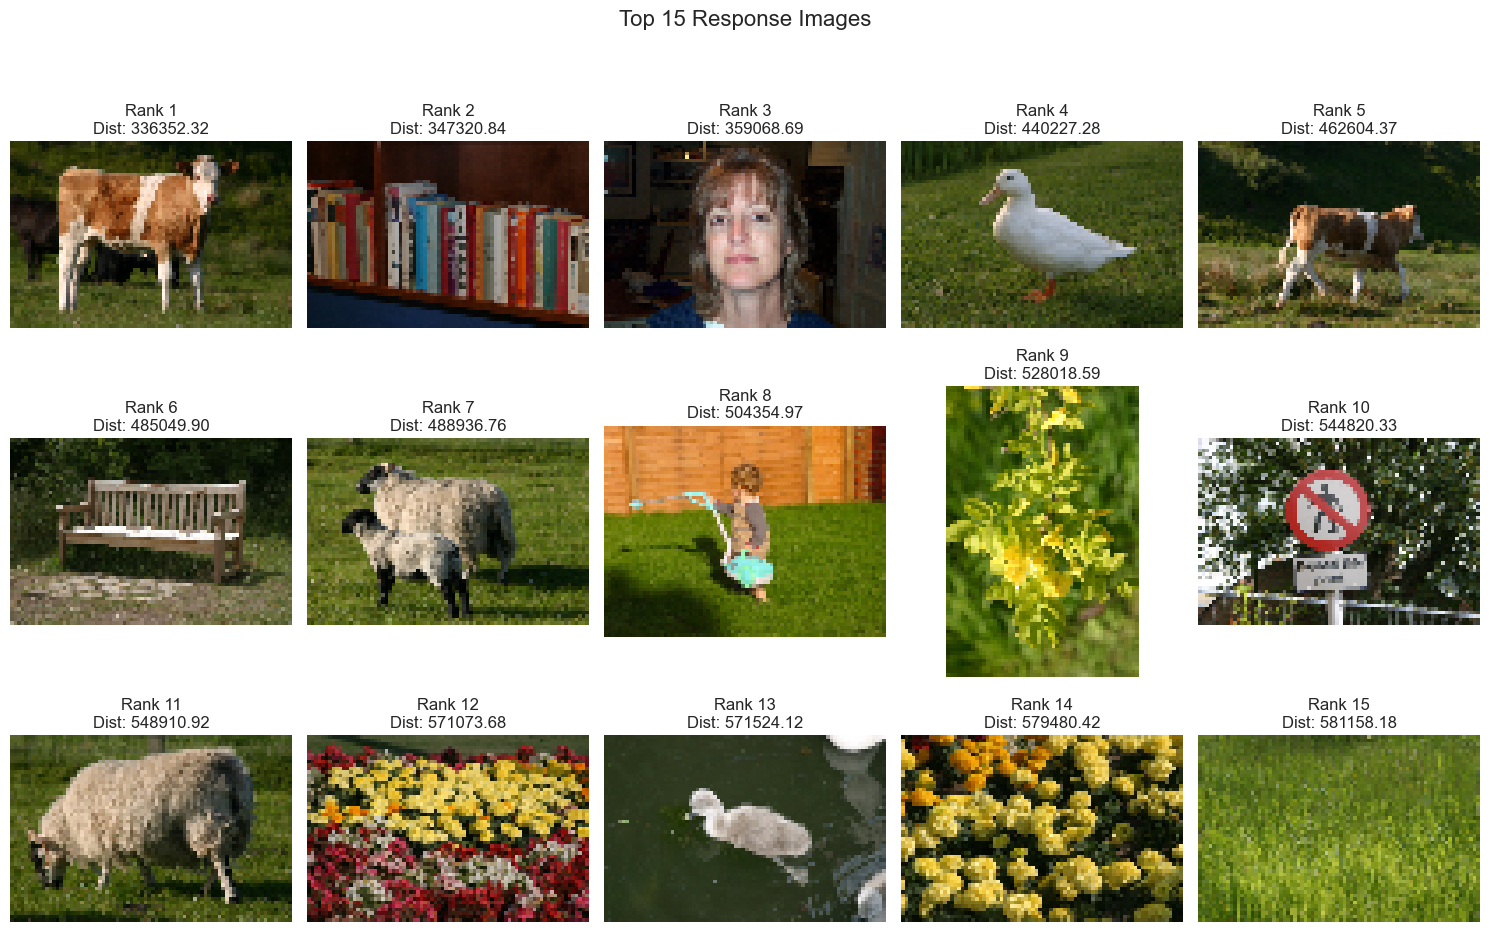

In [93]:
# Compute the distance between the query and all other descriptors
dst = []
COL_ANG_HIST_LEVEL = COLOR_HIST_ALLFEAT + ANGULAR_HIST_ALLFILES

query = COL_ANG_HIST_LEVEL[queryimg]
for i in range(NIMG):
    candidate = COL_ANG_HIST_LEVEL[i]
    distance = cvpr_compare(query, candidate,'L2') 
    dst.append((distance, i))

# Sort the distances
dst.sort(key=lambda x: x[0])

# Display the query image
plt.figure(figsize=(5, 5))
query_image_path = COLOR_HIST_ALLFILES[queryimg]
query_image = cv2.imread(query_image_path)
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
plt.imshow(query_image)
plt.title("Query Image")
plt.axis('off')
plt.show()

# Display the top 15 response images in a 3x5 grid layout
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle("Top 15 Response Images", fontsize=16)

for i in range(SHOW):
    img_index = dst[i + 1][1]  # Skipping the query image itself
    img_path = COLOR_HIST_ALLFILES[img_index]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4))  # Resize image for display

    # Determine position in the grid
    row, col = divmod(i, 5)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Rank {i + 1}\nDist: {dst[i + 1][0]:.2f}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top to fit the main title
plt.show()

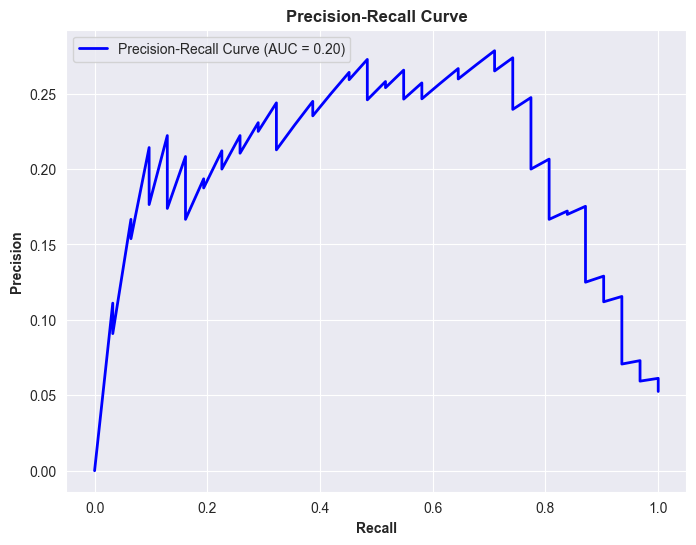

In [94]:
from cvpr_evaluation import extract_class_and_file

response_class_no = []
for img_no in range(len(COLOR_HIST_ALLFILES)):
    temp_class , temp_file = extract_class_and_file(COLOR_HIST_ALLFILES[dst[img_no][1]])
    response_class_no.append(temp_class)
    

query_class =   response_class_no[0]
response_class = response_class_no[1:]

precision = []
recall = []
relevant_retrieved = 0
total_relevant = sum(1 for cls in response_class if cls == query_class)

for i, cls in enumerate(response_class):
    if cls == query_class:
        relevant_retrieved += 1
    
    current_precision = relevant_retrieved / (i + 1)
    current_recall = relevant_retrieved / total_relevant if total_relevant > 0 else 0

    precision.append(current_precision)
    recall.append(current_recall)

# Calculate AUC for the curve
pr_auc = auc(recall, precision)

# Set the style
sns.set_style("darkgrid")

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall', fontweight='bold')
plt.ylabel('Precision', fontweight='bold')
plt.title('Precision-Recall Curve', fontweight='bold')
plt.legend(loc='best')
plt.show()

# Task 4 : Use of PCA  

In [101]:
import numpy as np
from sklearn.decomposition import PCA

def perform_pca(data, n_components=0.95):
    """
    Perform PCA on the given data and return reduced dataset, eigenvectors, and eigenvalues.

    Parameters:
        data (numpy.ndarray): The input data array (shape: [n_samples, n_features]).
        n_components (int or float): Number of components to keep. 
                                      If float, it represents the percentage of variance to retain.

    Returns:
        reduced_data (numpy.ndarray): The PCA transformed data.
        eigenvectors (numpy.ndarray): The eigenvectors of the PCA.
        eigenvalues (numpy.ndarray): The eigenvalues of the PCA.
    """
    # Create a PCA object
    pca = PCA(n_components=n_components)

    # Fit PCA on the data and transform it
    reduced_data = pca.fit_transform(data)

    # Get the eigenvalues and eigenvectors
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_

    return reduced_data, eigenvectors, eigenvalues


# Perform PCA
reduced_data, eigenvectors, eigenvalues = perform_pca(COL_ANG_HIST_LEVEL)

# Check the shapes of the returned values
print("Reduced data shape:", reduced_data.shape)
print("Eigenvalues:", eigenvalues)
print("Eigenvectors shape:", eigenvectors.shape)


Reduced data shape: (591, 6)
Eigenvalues: [8.14007796e+11 5.06915378e+11 3.47554498e+11 2.76333732e+11
 1.87083771e+11 1.27110879e+11]
Eigenvectors shape: (6, 8)


In [102]:
COLOR_HIST_ALLFEAT

array([[ 486413, 1367944, 1662028, ...,  196231,   64040,   41826],
       [ 650110,  975850,  902972, ...,  918140,  103655,   18970],
       [ 576209, 1292940,  471499, ...,  658301,  400134,  283054],
       ...,
       [ 232839,  702738, 1786515, ...,  119596,   46066,  212474],
       [ 972692, 1300698,  610590, ...,  805378,  110745,   70216],
       [2126499, 1055158,  550487, ...,  311861,   38487,    2396]])

In [103]:
# Perform PCA
reduced_data, eigenvectors, eigenvalues = perform_pca(COLOR_HIST_ALLFEAT)

# Check the shapes of the returned values
print("Reduced data shape:", reduced_data.shape)
print("Eigenvalues:", eigenvalues)
print("Eigenvectors shape:", eigenvectors.shape)

Reduced data shape: (591, 6)
Eigenvalues: [8.13950261e+11 5.06961759e+11 3.47564193e+11 2.76225317e+11
 1.87172088e+11 1.27081962e+11]
Eigenvectors shape: (6, 8)


In [105]:
from sklearn.decomposition import PCA


pca = PCA().fit(COLOR_HIST_ALLFEAT)
pca.components_

array([[ 8.04702690e-01,  2.99846315e-01, -1.20553279e-01,
        -3.09041538e-01, -3.11461831e-01, -1.97473646e-01,
        -1.03568457e-01, -7.59951625e-02],
       [ 2.97120020e-01, -5.52479995e-01, -5.58874296e-01,
        -1.61422810e-01,  2.86432034e-01,  3.49207650e-01,
         2.04468553e-01,  1.49301926e-01],
       [-3.23157484e-01,  2.76167674e-01, -9.39445817e-02,
        -5.62973431e-01, -2.90496383e-01,  1.40841105e-01,
         2.70367859e-01,  5.62328056e-01],
       [ 1.52234689e-01, -5.01184652e-01,  2.17044478e-01,
         3.30964121e-01, -4.56804907e-01, -2.79459469e-01,
         8.44062844e-03,  5.31181162e-01],
       [ 3.67172601e-02, -1.92851451e-01,  3.08445351e-01,
        -5.04496376e-02, -5.08622579e-01,  5.44800738e-01,
         3.34462179e-01, -4.43177999e-01],
       [-1.08789345e-01,  3.03098116e-01, -6.25389171e-01,
         5.40719868e-01, -3.35110347e-01, -4.63786328e-02,
         3.02815031e-01, -8.16085450e-02],
       [ 1.03982266e-04, -1.206813